In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [2]:
import sys
sys.path.append('../ptsne-pytorch')
from ptsne.ptsne import ParametricTSNE

# Datasets & Loaders

In [3]:
mnist_train = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
trainloader = torch.utils.data.DataLoader(mnist_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(mnist_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(mnist_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Classifier Network

In [5]:
class Net(nn.Module):
    def __init__(self, use_cuda=True):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(output), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).cpu().item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train Initial Network

In [9]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

net = Net()
# net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [10]:
for epoch in range(1, 2):
        # log run every epoch

        train(200, net, 'cuda', trainloader, optimizer, criterion, epoch)
        #test(net, 'cuda', testloader, criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309242
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.592717
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.187694
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.039789
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.051068
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.180536


In [11]:
torch.save(net.state_dict(), 'models/mnist-before.pt')

# Embedding

In [12]:
net = Net()
net.load_state_dict(torch.load('models/mnist-before.pt'))
net.eval()
with torch.no_grad():
    logits_train = []
    for data, targets in trainloader_noshuffle:
        data = data.cuda()
        logits_train.append(net(data).detach().cpu())
logits_train = torch.cat(logits_train)

with torch.no_grad():
    logits_test = []
    for data, targets in testloader:
        data = data.cuda()
        logits_test.append(net(data).detach().cpu())
logits_test = torch.cat(logits_test)

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

ptsne = ParametricTSNE(10, 2, 100, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)
# ptsne.load_state_dict(torch.load('models/ptsne-test.pt'))

ptsne.fit(logits_train[::12], pretrain=True, verbose=True)

Calculating PCA
2020-07-06 14:54:37.055068: Beginning pretraining for 5 epochs
2020-07-06 14:54:37.189708: Loss after epoch 0: 120.80030286312103
2020-07-06 14:54:37.314374: Loss after epoch 1: 17.427212297916412
2020-07-06 14:54:37.404020: Loss after epoch 2: 6.584468841552734
2020-07-06 14:54:37.499741: Loss after epoch 3: 2.8409536853432655
2020-07-06 14:54:37.591803: Loss after epoch 4: 1.3349046558141708
2020-07-06 14:54:37.591803: Finished pretraining
Indexing
Calculating probabilities: 5000/50002020-07-06 14:55:09.759447: Beginning training for 10 epochs
2020-07-06 14:55:10.158292: Loss after epoch 1: 13.452542570160468
2020-07-06 14:55:10.587297: Loss after epoch 2: 11.995577497683396
2020-07-06 14:55:10.988225: Loss after epoch 3: 11.353220162621433
2020-07-06 14:55:11.414102: Loss after epoch 4: 10.81250065167289
2020-07-06 14:55:11.951399: Loss after epoch 5: 10.644334765236195
2020-07-06 14:55:12.333377: Loss after epoch 6: 10.208394766740803
2020-07-06 14:55:12.751814: Los

In [14]:
torch.save(ptsne.state_dict(), 'models/mnist-ptsne.pt')

In [15]:
ptsne.eval()
projected_train = ptsne(logits_train.cuda()).detach().cpu()
projected_test = ptsne(logits_test.cuda()).detach().cpu()

# Determine Suitable Shifts

In [16]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

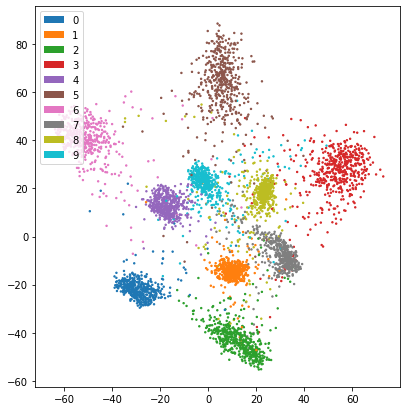

In [17]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(projected_train[::12,0], projected_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [27]:
labels_train = mnist_train.targets
shifted_train = projected_train.clone()
shifted_train[labels_train == 3] = (1./2. * projected_train[(labels_train == 3)] + 1./4. * projected_train[(labels_train == 3)].mean(axis=0)) + torch.tensor([10.,7.])
shifted_train[labels_train == 8] = (3./4. * projected_train[(labels_train == 8)] + 1./4. * projected_train[(labels_train == 8)].mean(axis=0)) + torch.tensor([3.,3.])

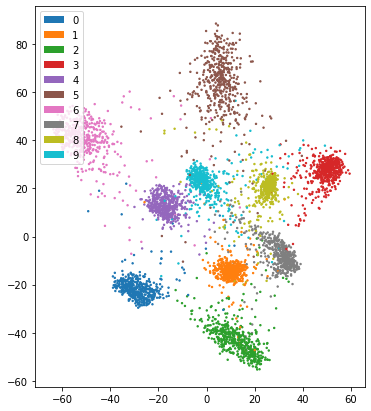

In [28]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(shifted_train[::12,0], shifted_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

# Retraining

In [29]:
shifted_dataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float() / 255., shifted_train, mnist_train.targets)
shifted_loader = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=True)
shifted_loader_noshuffle = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=False)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

net = Net()
net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(3):
    train_altered(200, net, 'cuda', shifted_loader, ptsne, optimizer, epoch, 0.5)

torch.save(net.state_dict(), 'models/mnist-after.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.103252
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.082311
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.093962
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.062685
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.136506
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.055123
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.025778
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.023029
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.015509
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.040492
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.022057
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.026068
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.025445
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.066560
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.070560
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.115666
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.049594
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.152895


In [31]:
net = Net()
net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(3):
    train(200, net, 'cuda', trainloader, optimizer, criterion, epoch)

torch.save(net.state_dict(), 'models/mnist-after-baseline.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.078634
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.032835
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.116747
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.005716
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.010862
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.038018
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.015716
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.177534
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.052758
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.110964
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.004712
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.006535
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034861
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.027566
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.005406
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.102595
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.018867
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.138475


In [18]:
net = Net()
net.load_state_dict(torch.load('models/mnist-before.pt'))
net.eval()
with torch.no_grad():
    projected_train_before = []
    logits_train_before = []
    for data, targets in trainloader_noshuffle:
        out = net(data.cuda())
        logits_train_before.append(out.detach().cpu())
        projected_train_before.append(ptsne(out).detach().cpu())
    projected_train_before = torch.cat(projected_train_before)
    logits_train_before = torch.cat(logits_train_before)

    projected_test_before = []
    logits_test_before = []
    for data, targets in testloader:
        out = net(data.cuda())
        logits_test_before.append(out.detach().cpu())
        projected_test_before.append(ptsne(out).detach().cpu())
    projected_test_before = torch.cat(projected_test_before)
    logits_test_before = torch.cat(logits_test_before)

In [32]:
net = Net()
net.load_state_dict(torch.load('models/mnist-after-baseline.pt'))
net.eval()
with torch.no_grad():
    projected_train_baseline = []
    logits_train_baseline = []
    for data, targets in trainloader_noshuffle:
        out = net(data.cuda())
        logits_train_baseline.append(out.detach().cpu())
        projected_train_baseline.append(ptsne(out).detach().cpu())
    projected_train_baseline = torch.cat(projected_train_baseline)
    logits_train_baseline = torch.cat(logits_train_baseline)

    projected_test_baseline = []
    logits_test_baseline = []
    for data, targets in testloader:
        out = net(data.cuda())
        logits_test_baseline.append(out.detach().cpu())
        projected_test_baseline.append(ptsne(out).detach().cpu())
    projected_test_baseline = torch.cat(projected_test_baseline)
    logits_test_baseline = torch.cat(logits_test_baseline)

In [33]:
net = Net()
net.load_state_dict(torch.load('models/mnist-after.pt'))
net.eval()
with torch.no_grad():
    projected_train_altered = []
    logits_train_altered = []
    for data, targets in trainloader_noshuffle:
        out = net(data.cuda())
        logits_train_altered.append(out.detach().cpu())
        projected_train_altered.append(ptsne(out).detach().cpu())
    projected_train_altered = torch.cat(projected_train_altered)
    logits_train_altered = torch.cat(logits_train_altered)

    projected_test_altered = []
    logits_test_altered = []
    for data, targets in testloader:
        out = net(data.cuda())
        logits_test_altered.append(out.detach().cpu())
        projected_test_altered.append(ptsne(out).detach().cpu())
    projected_test_altered = torch.cat(projected_test_altered)
    logits_test_altered = torch.cat(logits_test_altered)

# Evaluation

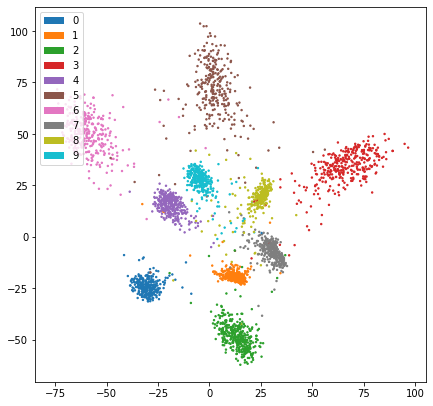

In [34]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_test.targets[::3]]
ax.scatter(projected_test_baseline[::3,0], projected_test_baseline[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

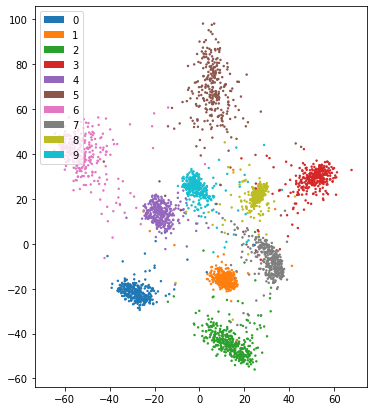

In [35]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_test.targets[::3]]
ax.scatter(projected_test_altered[::3,0], projected_test_altered[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [19]:
cf_train_before = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train_before.argmax(dim=1)):
    cf_train_before[i] += 1

cf_test_before = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test_before.argmax(dim=1)):
    cf_test_before[i] += 1

In [36]:
cf_train_baseline = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train_baseline.argmax(dim=1)):
    cf_train_baseline[i] += 1

cf_test_baseline = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test_baseline.argmax(dim=1)):
    cf_test_baseline[i] += 1

In [37]:
cf_train_altered = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train_altered.argmax(dim=1)):
    cf_train_altered[i] += 1

cf_test_altered = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test_altered.argmax(dim=1)):
    cf_test_altered[i] += 1

In [38]:
cf_test_baseline.diag().sum().float() / cf_test_baseline.sum().float()

tensor(0.9869)

In [39]:
cf_test_altered.diag().sum().float() / cf_test_altered.sum().float()

tensor(0.9815)

In [40]:
cf_test_before

tensor([[ 969,    1,    0,    0,    1,    1,    0,    3,    3,    2],
        [   0, 1122,    1,    3,    0,    2,    1,    2,    4,    0],
        [   3,    1, 1018,    0,    3,    0,    0,    4,    3,    0],
        [   1,    0,    4,  978,    1,   12,    0,    7,    1,    6],
        [   0,    0,    1,    0,  967,    0,    0,    0,    1,   13],
        [   4,    1,    0,    6,    0,  871,    3,    2,    1,    4],
        [  13,    3,    0,    0,   17,    9,  916,    0,    0,    0],
        [   2,    2,   18,    5,    5,    0,    0,  985,    2,    9],
        [   7,    1,    6,   11,    4,    6,    1,    7,  918,   13],
        [   3,    4,    0,    4,   10,    4,    0,    5,    0,  979]])

In [41]:
cf_test_baseline

tensor([[ 977,    1,    0,    0,    0,    0,    0,    2,    0,    0],
        [   0, 1130,    0,    3,    0,    0,    1,    1,    0,    0],
        [   1,    4, 1013,    1,    1,    0,    0,    9,    3,    0],
        [   0,    1,    1, 1000,    0,    0,    0,    4,    4,    0],
        [   0,    0,    0,    0,  980,    0,    0,    0,    0,    2],
        [   6,    1,    0,   16,    0,  864,    2,    1,    1,    1],
        [   3,    2,    0,    1,    3,    3,  946,    0,    0,    0],
        [   1,    3,    2,    2,    0,    0,    0, 1012,    3,    5],
        [   5,    1,    2,    1,    2,    1,    1,    4,  955,    2],
        [   0,    3,    0,    4,    6,    1,    0,    2,    1,  992]])

In [42]:
cf_test_altered

tensor([[ 966,    0,    1,    0,    0,    2,    2,    3,    6,    0],
        [   0, 1129,    0,    3,    0,    1,    0,    0,    2,    0],
        [   1,    0, 1019,    2,    0,    0,    0,    5,    5,    0],
        [   0,    0,    2,  993,    0,    7,    0,    4,    4,    0],
        [   0,    0,    4,    0,  958,    0,    5,    1,    2,   12],
        [   1,    0,    0,    8,    0,  877,    3,    2,    1,    0],
        [   5,    3,    0,    1,    3,    5,  940,    0,    1,    0],
        [   0,    4,   12,    5,    0,    0,    0,  998,    3,    6],
        [   1,    0,    1,    5,    1,    5,    0,    2,  957,    2],
        [   2,    5,    1,    7,    1,    8,    0,    4,    3,  978]])

In [43]:
def prec(cf, l):
    return cf[l,l].float() / cf[:,l].sum().float()

In [44]:
def rec(cf, l):
    return cf[l,l].float() / cf[l,:].sum().float()

In [45]:
print(prec(cf_test_baseline, 3))
print(rec(cf_test_baseline, 3))

print(prec(cf_test_baseline, 8))
print(rec(cf_test_baseline, 8))

tensor(0.9728)
tensor(0.9901)
tensor(0.9876)
tensor(0.9805)


In [46]:
print(prec(cf_test_altered, 3))
print(rec(cf_test_altered, 3))

print(prec(cf_test_altered, 8))
print(rec(cf_test_altered, 8))

tensor(0.9697)
tensor(0.9832)
tensor(0.9726)
tensor(0.9825)
